# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from newsapi import NewsApiClient
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
load_dotenv()


%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ryanc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

Bad key "text.kerning_factor" on line 4 in
C:\Users\ryanc\anaconda3\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read your api key environment variable
api_key = os.getenv("news_api")

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [28]:
# Fetch the Bitcoin news articles
bitcoin_news = newsapi.get_everything(q="bitcoin", language="en")


NameError: name 'articles' is not defined

In [5]:
# Fetch the Ethereum news articles
ethereum_news = newsapi.get_everything(q="ethereum", language="en")

In [29]:
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [7]:
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result


In [8]:
# Create the Bitcoin sentiment scores DataFrame
bitcoin_df = create_df(bitcoin_news["articles"], "en")
bitcoin_df.head()

,date,description,language,text,title
0,2021-02-08,Elon Musk’s cryptocurrency hype was more than ...,en,Elon Musks cryptocurrency hype was more than j...,"Tesla buys $1.5 in Bitcoin, will soon accept i..."
1,2021-02-09,Tesla announced this week that it purchased $1...,en,"Tesla, led by Elon Musk, confirmed that it pur...",Tesla’s $1.5 billion bitcoin purchase clashes ...
2,2021-02-09,The maker of electric vehicles said it had inv...,en,"For a brief moment on Sunday, before Tesla sai...",Would You Trade a Bitcoin for a Tesla?
3,2021-02-12,Twitter and Square CEO Jack Dorsey and rapper ...,en,Twitter and Square CEO Jack Dorsey and rapper ...,Jack Dorsey and Jay Z invest $23.6 million to ...
4,2021-02-08,"Today in an SEC filing, Tesla disclosed that i...",en,"Today in an SEC filing, Tesla disclosed that i...","Tesla buys $1.5B in bitcoin, may accept the cr..."


In [9]:
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in bitcoin_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
bitcoin_df = bitcoin_df.join(title_sentiment_df).join(text_sentiment_df)

bitcoin_df.head()


,date,description,language,text,title,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,2021-02-08,Elon Musk’s cryptocurrency hype was more than ...,en,Elon Musks cryptocurrency hype was more than j...,"Tesla buys $1.5 in Bitcoin, will soon accept i...",0.3818,0.206,0.794,0.0,1,0.3182,0.091,0.909,0.000,1.0
1,2021-02-09,Tesla announced this week that it purchased $1...,en,"Tesla, led by Elon Musk, confirmed that it pur...",Tesla’s $1.5 billion bitcoin purchase clashes ...,0.0000,0.000,1.000,0.0,0,0.3818,0.071,0.929,0.000,1.0
2,2021-02-09,The maker of electric vehicles said it had inv...,en,"For a brief moment on Sunday, before Tesla sai...",Would You Trade a Bitcoin for a Tesla?,0.0000,0.000,1.000,0.0,0,-0.1027,0.000,0.962,0.038,-1.0
3,2021-02-12,Twitter and Square CEO Jack Dorsey and rapper ...,en,Twitter and Square CEO Jack Dorsey and rapper ...,Jack Dorsey and Jay Z invest $23.6 million to ...,0.0000,0.000,1.000,0.0,0,0.2500,0.056,0.944,0.000,1.0
4,2021-02-08,"Today in an SEC filing, Tesla disclosed that i...",en,"Today in an SEC filing, Tesla disclosed that i...","Tesla buys $1.5B in bitcoin, may accept the cr...",0.3818,0.167,0.833,0.0,1,0.6597,0.137,0.863,0.000,1.0


In [10]:
# Create the Ethereum sentiment scores DataFrame
ethereum_df = create_df(ethereum_news["articles"], "en")
ethereum_df.head()

,date,description,language,text,title
0,2021-02-18,Worried that the GeForce RTX 3060 will be sold...,en,Worried that the GeForce RTX 3060 will be sold...,NVIDIA limits RTX 3060 crypto speeds as it int...
1,2021-02-04,Ethereum hit an all-time high on Thursday as i...,en,FILE PHOTO: Representation of the Ethereum vir...,Ethereum scales record peak before futures lau...
2,2021-02-03,"Ethereum hit all-time highs on Wednesday, brea...",en,By Reuters Staff\r\nFILE PHOTO: Representation...,Cryptocurrency Ethereum hits record high ahead...
3,2021-02-27,"Digital content has value, and crypto collecto...",en,NFTs (non-fungible tokens) — or scarce digital...,"If you haven’t followed NFTs, here’s why you s..."
4,2021-02-20,While the first Christie's auction of digital ...,en,While the first Christie's auction of digital ...,Remastered 'nyan cat' art sells for the equiva...


In [11]:
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in ethereum_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
ethereum_df = ethereum_df.join(title_sentiment_df).join(text_sentiment_df)

ethereum_df.head()

,date,description,language,text,title,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,2021-02-18,Worried that the GeForce RTX 3060 will be sold...,en,Worried that the GeForce RTX 3060 will be sold...,NVIDIA limits RTX 3060 crypto speeds as it int...,0.0,0.0,1.0,0.0,0,-0.3400,0.063,0.818,0.119,-1
1,2021-02-04,Ethereum hit an all-time high on Thursday as i...,en,FILE PHOTO: Representation of the Ethereum vir...,Ethereum scales record peak before futures lau...,0.0,0.0,1.0,0.0,0,0.0000,0.000,1.000,0.000,0
2,2021-02-03,"Ethereum hit all-time highs on Wednesday, brea...",en,By Reuters Staff\r\nFILE PHOTO: Representation...,Cryptocurrency Ethereum hits record high ahead...,0.0,0.0,1.0,0.0,0,0.0000,0.000,1.000,0.000,0
3,2021-02-27,"Digital content has value, and crypto collecto...",en,NFTs (non-fungible tokens) — or scarce digital...,"If you haven’t followed NFTs, here’s why you s...",0.0,0.0,1.0,0.0,0,0.4404,0.091,0.909,0.000,1
4,2021-02-20,While the first Christie's auction of digital ...,en,While the first Christie's auction of digital ...,Remastered 'nyan cat' art sells for the equiva...,0.0,0.0,1.0,0.0,0,0.0258,0.030,0.970,0.000,0


In [12]:
# Describe the Bitcoin Sentiment
bitcoin_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.00000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.071455,0.086550,0.885050,0.028400,0.15000,0.282756,0.077333,0.909889,0.012722,0.555556
std,0.282659,0.149916,0.152571,0.077318,0.67082,0.332195,0.064251,0.059923,0.026797,0.783823
min,-0.542300,0.000000,0.508000,0.000000,-1.00000,-0.381800,0.000000,0.754000,0.000000,-1.000000
25%,0.000000,0.000000,0.789500,0.000000,0.00000,0.025675,0.042750,0.869000,0.000000,0.250000
50%,0.000000,0.000000,1.000000,0.000000,0.00000,0.284100,0.068500,0.914000,0.000000,1.000000
75%,0.366350,0.176750,1.000000,0.000000,1.00000,0.559650,0.110000,0.952250,0.000000,1.000000
max,0.585900,0.492000,1.000000,0.304000,1.00000,0.831600,0.246000,1.000000,0.082000,1.000000


In [13]:
# Describe the Ethereum Sentiment
ethereum_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.00992,0.070400,0.876650,0.052950,-0.050000,0.221340,0.056950,0.937100,0.005950,0.450000
std,0.24900,0.135791,0.153864,0.102718,0.686333,0.287580,0.055042,0.061753,0.026609,0.604805
min,-0.54230,0.000000,0.606000,0.000000,-1.000000,-0.340000,0.000000,0.818000,0.000000,-1.000000
25%,-0.03200,0.000000,0.716250,0.000000,-0.250000,0.000000,0.000000,0.883500,0.000000,0.000000
50%,0.00000,0.000000,1.000000,0.000000,0.000000,0.172000,0.067000,0.929000,0.000000,0.500000
75%,0.00000,0.032500,1.000000,0.032500,0.000000,0.453775,0.096500,1.000000,0.000000,1.000000
max,0.44040,0.394000,1.000000,0.310000,1.000000,0.709600,0.144000,1.000000,0.119000,1.000000


### Questions:

Q: Which coin had the highest mean positive score?

A: Bitcoin

Q: Which coin had the highest compound score?

A: Bitcoin

Q. Which coin had the highest positive score?

A: Bitcoin

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [34]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [15]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
# YOUR CODE HERE!

In [16]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub("", text)
   
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
   
    # Convert the words to lowercase
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    
    # Remove the stop words
    
    
    return tokens

In [67]:
# Create a new tokens column for Bitcoin
bitcoin_tokens = tokenizer(str(bitcoin_df["text"]))

In [53]:
# Create a new tokens column for Ethereum
ethereum_tokens = tokenizer(str(ethereum_df["text"]))



---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [49]:
from collections import Counter
from nltk import ngrams

In [50]:
# Generate the Bitcoin N-grams where N=2
bitcoin_bigram = ngrams(bitcoin_tokens, n=2)

In [51]:
# Generate the Ethereum N-grams where N=2
ethereum_bigram = ngrams(ethereum_tokens, n=2)

In [55]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    top_10 = dict(Counter(tokens).most_common(10))
    return Counter(tokens).most_common(N)

In [61]:
# Use token_count to get the top 10 words for Bitcoin
token_count(bitcoin_tokens, N=10)

[('bitcoin', 4),
 ('tesla', 3),
 ('elon', 2),
 ('jack', 2),
 ('dorsey', 2),
 ('none', 2),
 ('morning', 2),
 ('ha', 2),
 ('musks', 1),
 ('cryptocurrency', 1)]

In [62]:
# Use token_count to get the top 10 words for Ethereum
token_count(ethereum_tokens, N=10)

[('reuters', 10),
 ('photo', 4),
 ('ethereum', 4),
 ('new', 4),
 ('york', 4),
 ('representation', 3),
 ('feb', 3),
 ('dollar', 3),
 ('file', 2),
 ('vir', 2)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

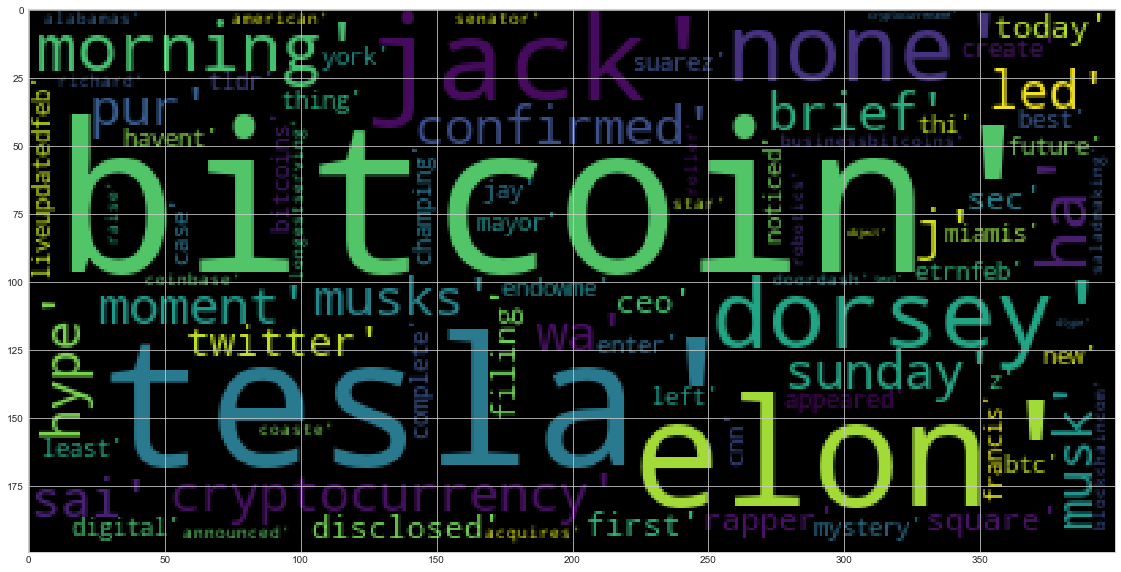

In [68]:
# Generate the Bitcoin word cloud
wc = WordCloud().generate(str(bitcoin_tokens))
plt.imshow(wc)

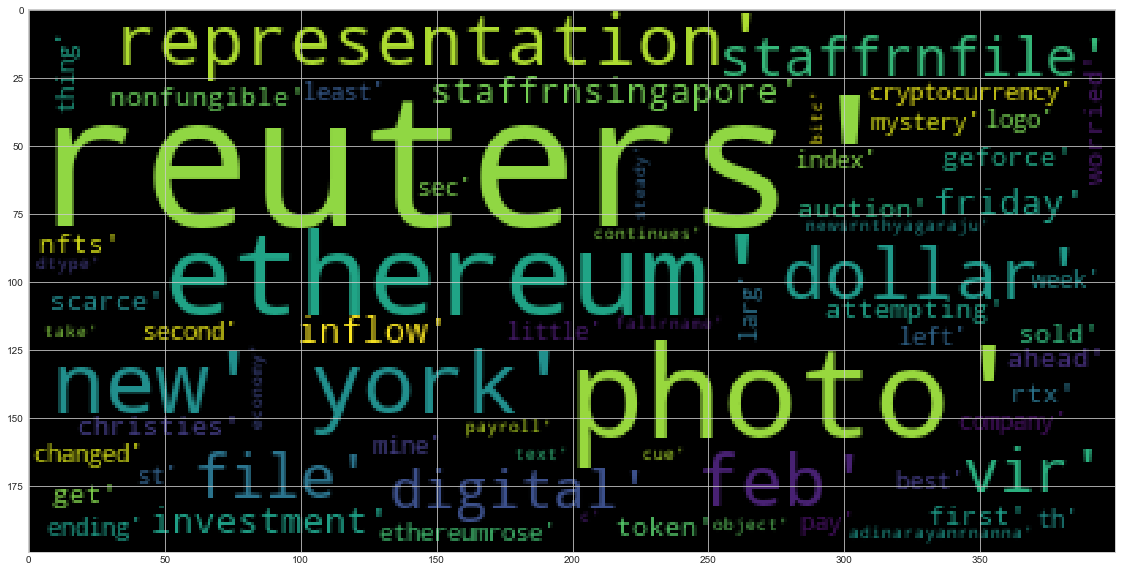

In [69]:
# Generate the Ethereum word cloud
wc = WordCloud().generate(str(ethereum_tokens))
plt.imshow(wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [70]:
import spacy
from spacy import displacy

In [25]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [71]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [77]:
# Concatenate all of the Bitcoin text togetheR
all_bitcoin_text = str(bitcoin_df["text"])

In [78]:
# Run the NER processor on all of the text
bitcoin_doc = nlp(all_bitcoin_text)

# Add a title to the document
# YOUR CODE HERE!

In [81]:
# Render the visualization
displacy.render(bitcoin_doc, style='ent')

In [84]:
# List all Entities
print([ent.text for ent in bitcoin_doc.ents])

['Elon Musk', 'Sunday', 'Tesla', 'Twitter', 'Square', 'Jack Dorsey', 'Today', 'SEC', 'Tesla', 'Bitcoin', 'first', 'Feb. 9, 2021', '8:01 a.m.', 'Bitcoin', 'this morning', 'Jack Dorsey', 'Jay Z', 'Bitcoins', 'Francis Suarez', 'New York', 'CNN', 'Alabamas', 'Richard S', '17', 'Blockchain.com', '18', 'DoorDash', 'This morning', 'Coinbase', 'American']


---

### Ethereum NER

In [85]:
# Concatenate all of the Ethereum text together
all_ethereum_text = str(ethereum_df["text"])

In [86]:
# Run the NER processor on all of the text
ethereum_doc = nlp(all_ethereum_text)

# Add a title to the document
# YOUR CODE HERE!

In [87]:
# Render the visualization
displacy.render(ethereum_doc, style='ent')

In [89]:
# List all Entities
print([ent.text for ent in ethereum_doc.ents])

['GeForce', '3060', 'Ethereum', 'Reuters', 'first', "Christie's", 'Reuters', 'Reuters', 'Feb 9', 'Reuters', 'NEW YORK', 'Reuters', 'second', 'NEW YORK', 'Feb 18', 'Reuters', '10', 'Ethereum', 'Friday', '7.34%', 'the week ending 21st', 'NEW YORK', 'Reuters', '16', 'Reuters', 'Reuters', 'NEW YORK', 'Feb 8', 'Reuters', '18', '19', 'Friday']


---